In [1]:
from stable_baselines3 import TD3, SAC
from stable_baselines3.common.noise import NormalActionNoise

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym

from CSTR_model_plus import CSTRRLEnv


2025-03-12 12:38:27.537455: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 12:38:27.554531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741808307.575065 3071460 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741808307.581353 3071460 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 12:38:27.602701: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Pretraining using historical data...
Pretrained with historical best PID gains. Reward: -4.87171925438112
Starting CIRL-PSO training...


  2%|▏         | 1/50 [00:01<01:04,  1.31s/it]

Iteration 1/50: Best Score = -0.3234, Mean Score = -6.1749


 10%|█         | 5/50 [00:08<01:23,  1.85s/it]

Iteration 5/50: Best Score = -0.1288, Mean Score = -7.6467


 20%|██        | 10/50 [00:17<01:14,  1.87s/it]

Iteration 10/50: Best Score = -0.0521, Mean Score = -6.7584


 30%|███       | 15/50 [00:26<01:02,  1.79s/it]

Iteration 15/50: Best Score = -0.0521, Mean Score = -6.4743


 40%|████      | 20/50 [00:34<00:46,  1.55s/it]

Iteration 20/50: Best Score = -0.0510, Mean Score = -5.9708


 50%|█████     | 25/50 [00:41<00:36,  1.45s/it]

Iteration 25/50: Best Score = -0.0510, Mean Score = -6.3093


 60%|██████    | 30/50 [00:48<00:28,  1.44s/it]

Iteration 30/50: Best Score = -0.0502, Mean Score = -5.3462


 70%|███████   | 35/50 [00:55<00:19,  1.30s/it]

Iteration 35/50: Best Score = -0.0502, Mean Score = -4.1329


 80%|████████  | 40/50 [01:00<00:10,  1.10s/it]

Iteration 40/50: Best Score = -0.0502, Mean Score = -2.1800


 90%|█████████ | 45/50 [01:05<00:04,  1.01it/s]

Iteration 45/50: Best Score = -0.0502, Mean Score = -2.6292


100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

Iteration 50/50: Best Score = -0.0502, Mean Score = -2.0668
Training completed in 70.60 seconds
Best policy found with score: -0.0502


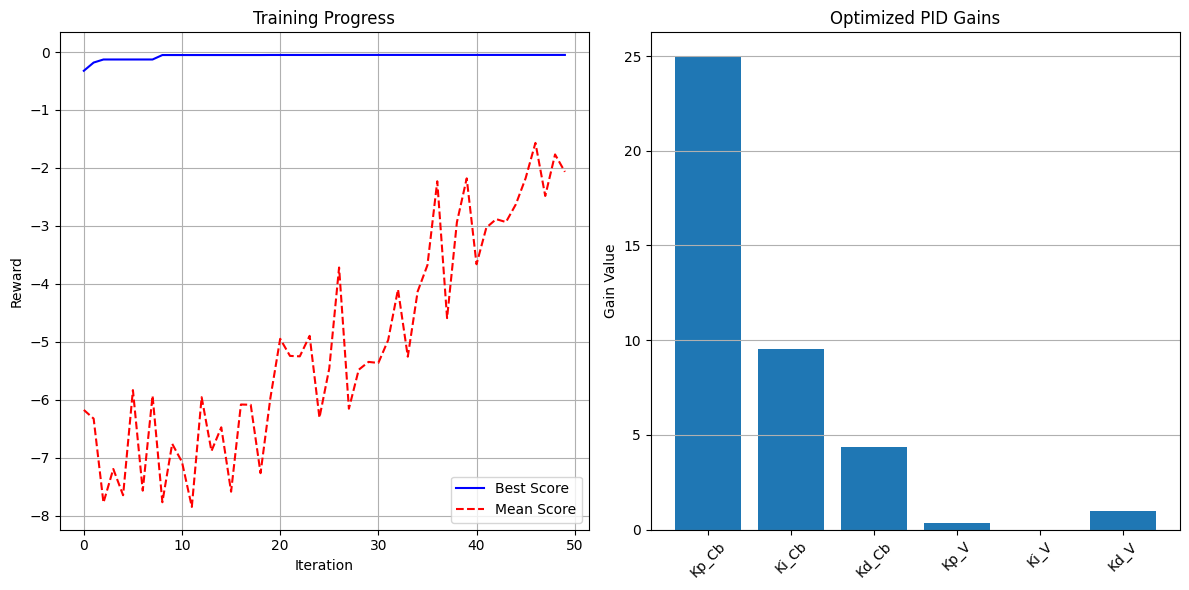

Starting fine-tuning process...
Fine-tuning iteration 1/10: Best Score = -0.1993, Mean Score = -0.2716
Fine-tuning iteration 2/10: Best Score = -0.1981, Mean Score = -0.2209
Fine-tuning iteration 3/10: Best Score = -0.1976, Mean Score = -0.2008
Fine-tuning iteration 4/10: Best Score = -0.1975, Mean Score = -0.1988
Fine-tuning iteration 5/10: Best Score = -0.1973, Mean Score = -0.1981
Fine-tuning iteration 6/10: Best Score = -0.1970, Mean Score = -0.1976
Fine-tuning iteration 7/10: Best Score = -0.1969, Mean Score = -0.1972
Fine-tuning iteration 8/10: Best Score = -0.1967, Mean Score = -0.1970
Fine-tuning iteration 9/10: Best Score = -0.1963, Mean Score = -0.1967
Fine-tuning iteration 10/10: Best Score = -0.1963, Mean Score = -0.1965
Comparing with baseline policy...
Evaluating policy...
Evaluation completed. Total reward: -0.1963
Evaluating policy...
Evaluation completed. Total reward: -15.0387
Comparison results:
  Cb MSE - Best: 0.001454, Baseline: 0.111398, Improvement: 98.69%
   V 

/tmp/ipykernel_3071460/387494661.py:455: RuntimeWarning: invalid value encountered in scalar divide
  v_improvement = ((baseline_mse_v - best_mse_v) / baseline_mse_v) * 100


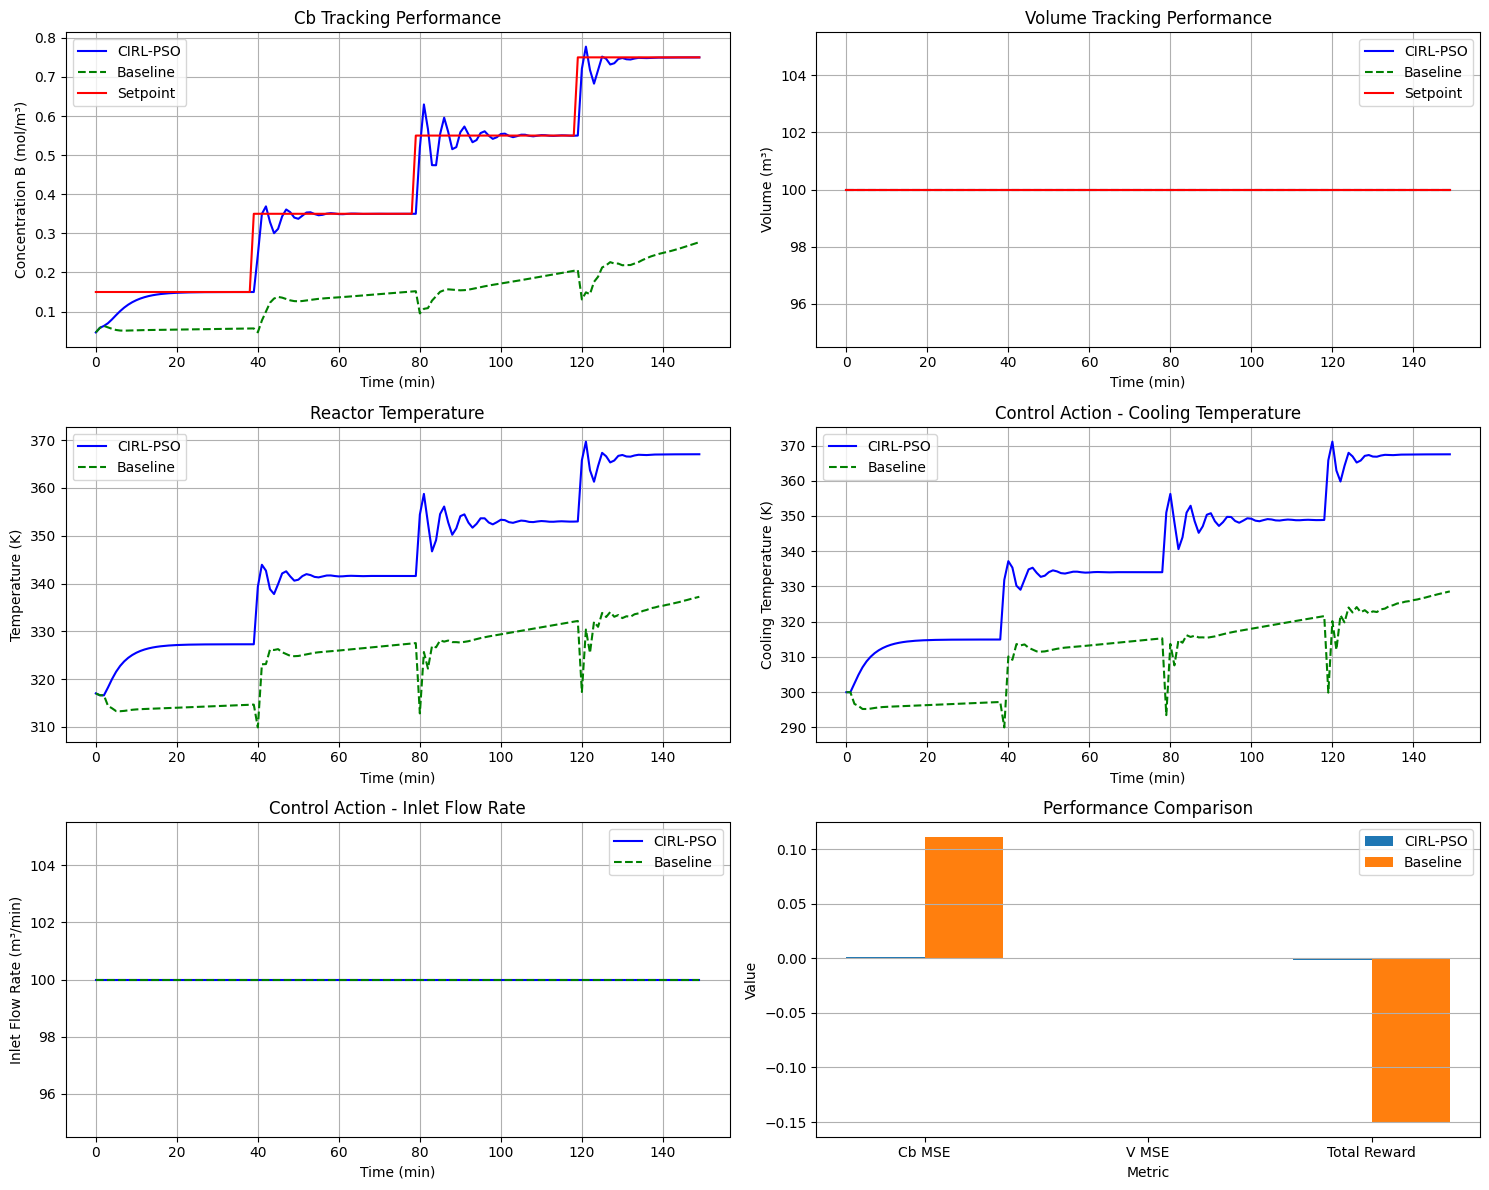

Evaluating policy...


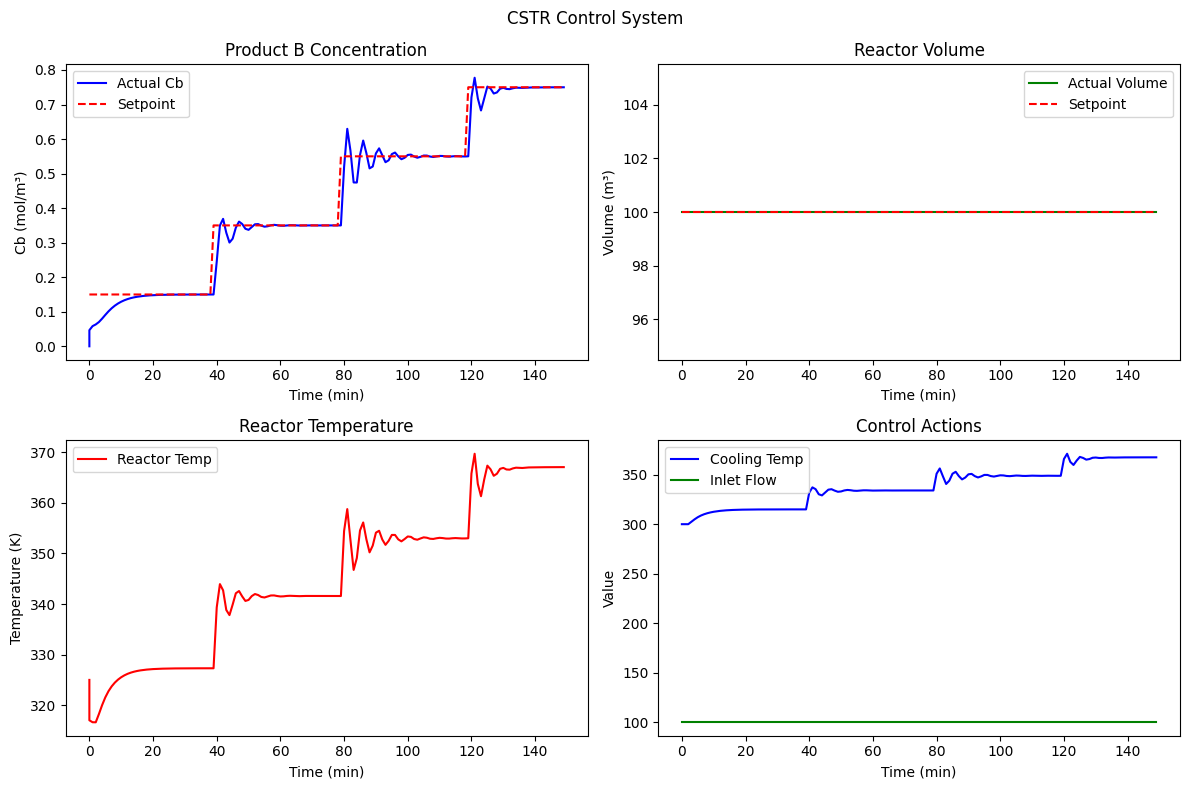

Evaluation completed. Total reward: -0.1963
CIRL-PSO Training and Evaluation Complete!
Best PID Gains: [25.          9.5436474   4.33916356  0.33731099  0.          1.        ]
Fine-tuned PID Gains: [24.55180748  9.58653827  4.41413345  0.48026004  0.          0.99943596]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from CSTR_model_plus import CSTRRLEnv
import time
from tqdm import tqdm

class PSOParticle:
    """
    Represents a single particle in the PSO algorithm.
    Each particle corresponds to a policy that outputs PID gains.
    """
    def __init__(self, dim, bounds):
        """
        Initialize a particle with random position and zero velocity.
        
        Args:
            dim: Dimensionality of the search space (number of policy parameters)
            bounds: List of tuples (min, max) for each dimension
        """
        # Initialize position randomly within bounds
        self.position = np.array([np.random.uniform(bounds[i][0], bounds[i][1]) 
                                  for i in range(dim)])
        self.velocity = np.zeros(dim)
        self.best_position = self.position.copy()
        self.best_score = -np.inf  # We maximize reward, so start with negative infinity

    def update_velocity(self, global_best_position, w=0.7, c1=1.5, c2=1.5):
        """
        Update the particle's velocity based on PSO equations.
        
        Args:
            global_best_position: The global best position across all particles
            w: Inertia weight
            c1: Cognitive parameter (personal best influence)
            c2: Social parameter (global best influence)
        """
        r1 = np.random.random(len(self.position))
        r2 = np.random.random(len(self.position))
        
        cognitive_component = c1 * r1 * (self.best_position - self.position)
        social_component = c2 * r2 * (global_best_position - self.position)
        
        self.velocity = w * self.velocity + cognitive_component + social_component

    def update_position(self, bounds):
        """
        Update the particle's position based on its velocity and enforce bounds.
        
        Args:
            bounds: List of tuples (min, max) for each dimension
        """
        self.position = self.position + self.velocity
        
        # Enforce bounds
        for i in range(len(self.position)):
            self.position[i] = np.clip(self.position[i], bounds[i][0], bounds[i][1])

    def evaluate(self, env, setpoints_Cb, setpoints_V, setpoint_durations):
        """
        Evaluate the particle by running an episode in the environment.
        The policy represented by this particle outputs PID gains.
        
        Args:
            env: The environment to evaluate on
            setpoints_Cb, setpoints_V, setpoint_durations: Setpoint tracking parameters
            
        Returns:
            total_reward: The total reward accumulated over the episode
        """
        # Reset environment with specific setpoint schedule
        options = {
            'setpoints_Cb': setpoints_Cb,
            'setpoints_V': setpoints_V,
            'setpoint_durations': setpoint_durations
        }
        obs, _ = env.reset(options=options)
        
        total_reward = 0
        done = False
        info = {}
        
        while not done:
            # The position of the particle represents the policy parameters
            # In PSO, we directly optimize the policy parameters (gains)
            action = self.position
            
            # Normalize action to [-1, 1] for the environment
            min_bounds = np.array([-5, 0, 0.02, 0, 0, 0.01])
            max_bounds = np.array([25, 20, 10, 1, 2, 1])
            normalized_action = 2 * ((action - min_bounds) / (max_bounds - min_bounds)) - 1
            
            # Clip to ensure within action bounds of environment
            normalized_action = np.clip(normalized_action, -1, 1)
            
            # Take a step in the environment
            obs, reward, done, truncated, info = env.step(normalized_action)
            total_reward += reward
            
            # Optional: Break early if the controller is performing extremely poorly
            if total_reward < -1000:
                return total_reward
            
        return total_reward


class CIRL_PSO:
    """
    CIRL (Continuous Iterative Reinforcement Learning) implementation using PSO
    for optimizing a control policy for setpoint tracking in a CSTR.
    """
    def __init__(self, env, num_particles=20, max_iterations=50):
        """
        Initialize the CIRL-PSO algorithm.
        
        Args:
            env: The environment to train on
            num_particles: Number of particles in the PSO swarm
            max_iterations: Maximum number of PSO iterations
        """
        self.env = env
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        
        # Dimensionality is 6 for the 6 PID gains
        self.dim = 6
        
        # Define bounds for the PID gains
        # [Kp_Cb, Ki_Cb, Kd_Cb, Kp_V, Ki_V, Kd_V]
        self.bounds = [
            (-5, 25),    # Kp_Cb
            (0, 20),     # Ki_Cb
            (0.02, 10),  # Kd_Cb
            (0, 1),      # Kp_V
            (0, 2),      # Ki_V
            (0.01, 1)    # Kd_V
        ]
        
        # Initialize particles
        self.particles = [PSOParticle(self.dim, self.bounds) for _ in range(num_particles)]
        
        # Initialize global best
        self.global_best_position = None
        self.global_best_score = -np.inf
        
        # For tracking training progress
        self.best_scores_history = []
        self.mean_scores_history = []

    def pretrain(self, historical_data=None):
        """
        Pretrain the policy using historical data if available.
        
        Args:
            historical_data: Dictionary containing historical PID gains, states, and rewards
        """
        if historical_data is None:
            print("No historical data available. Skipping pretraining.")
            return
        
        print("Pretraining using historical data...")
        
        # Here you would extract information from historical data to initialize particles
        # For example, initialize some particles near historically good parameter values
        
        # Simple implementation: set one particle to the best historical parameters
        if 'best_pid_gains' in historical_data:
            self.particles[0].position = historical_data['best_pid_gains']
            
            # Evaluate this particle
            reward = self.particles[0].evaluate(
                self.env, 
                historical_data.get('setpoints_Cb'), 
                historical_data.get('setpoints_V'),
                historical_data.get('setpoint_durations')
            )
            
            self.particles[0].best_score = reward
            self.particles[0].best_position = self.particles[0].position.copy()
            
            if reward > self.global_best_score:
                self.global_best_score = reward
                self.global_best_position = self.particles[0].position.copy()
                
            print(f"Pretrained with historical best PID gains. Reward: {reward}")

    def train(self, setpoints_Cb, setpoints_V, setpoint_durations):
        """
        Train the policy using PSO on the given setpoint tracking problem.
        
        Args:
            setpoints_Cb: List of setpoints for Cb concentration
            setpoints_V: List of setpoints for reactor volume
            setpoint_durations: List of durations for each setpoint
            
        Returns:
            best_policy: The best policy parameters found
            training_history: Dictionary containing training metrics
        """
        print("Starting CIRL-PSO training...")
        start_time = time.time()
        
        # Main PSO loop
        for iteration in tqdm(range(self.max_iterations)):
            iteration_scores = []
            
            # Evaluate each particle
            for particle in self.particles:
                # Evaluate the particle
                score = particle.evaluate(self.env, setpoints_Cb, setpoints_V, setpoint_durations)
                iteration_scores.append(score)
                
                # Update particle's best known position
                if score > particle.best_score:
                    particle.best_score = score
                    particle.best_position = particle.position.copy()
                
                # Update global best if needed
                if score > self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = particle.position.copy()
            
            # Update velocities and positions
            for particle in self.particles:
                # Adaptive parameters: reduce exploration over time
                w = 0.9 - (0.5 * iteration / self.max_iterations)
                c1 = 2.0 - (0.5 * iteration / self.max_iterations)
                c2 = 2.0 + (0.5 * iteration / self.max_iterations)
                
                particle.update_velocity(self.global_best_position, w, c1, c2)
                particle.update_position(self.bounds)
            
            # Track statistics
            mean_score = np.mean(iteration_scores)
            self.mean_scores_history.append(mean_score)
            self.best_scores_history.append(self.global_best_score)
            
            # Print progress
            if (iteration + 1) % 5 == 0 or iteration == 0:
                print(f"Iteration {iteration+1}/{self.max_iterations}: "
                      f"Best Score = {self.global_best_score:.4f}, "
                      f"Mean Score = {mean_score:.4f}")
        
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")
        print(f"Best policy found with score: {self.global_best_score:.4f}")
        
        # Normalize best policy to [-1, 1] for environment compatibility
        min_bounds = np.array([self.bounds[i][0] for i in range(self.dim)])
        max_bounds = np.array([self.bounds[i][1] for i in range(self.dim)])
        normalized_best_policy = 2 * ((self.global_best_position - min_bounds) / (max_bounds - min_bounds)) - 1
        
        training_history = {
            'best_scores': self.best_scores_history,
            'mean_scores': self.mean_scores_history,
            'best_pid_gains': self.global_best_position,
            'normalized_best_policy': normalized_best_policy,
            'training_time': training_time
        }
        
        return self.global_best_position, training_history

    def fine_tune(self, policy, setpoints_Cb, setpoints_V, setpoint_durations, iterations=10):
        """
        Fine-tune a policy on a new setpoint schedule.
        
        Args:
            policy: Initial policy parameters to fine-tune
            setpoints_Cb, setpoints_V, setpoint_durations: New setpoint schedule
            iterations: Number of fine-tuning iterations
            
        Returns:
            fine_tuned_policy: The fine-tuned policy parameters
            fine_tuning_history: Dictionary containing fine-tuning metrics
        """
        print("Starting fine-tuning process...")
        
        # Initialize the best particle with the given policy
        best_particle = PSOParticle(self.dim, self.bounds)
        best_particle.position = policy.copy()
        
        # Initialize the rest of the particles with small random perturbations
        particles = [best_particle]
        for _ in range(self.num_particles - 1):
            particle = PSOParticle(self.dim, self.bounds)
            # Initialize close to the best policy with some noise
            noise = np.random.normal(0, 0.1, self.dim)
            particle.position = np.clip(policy + noise, 
                                       [self.bounds[i][0] for i in range(self.dim)],
                                       [self.bounds[i][1] for i in range(self.dim)])
            particles.append(particle)
            
        # Initialize global best
        global_best_position = policy.copy()
        global_best_score = -np.inf
        
        # For tracking fine-tuning progress
        best_scores_history = []
        mean_scores_history = []
        
        # Fine-tuning loop
        for iteration in range(iterations):
            iteration_scores = []
            
            # Evaluate each particle
            for particle in particles:
                score = particle.evaluate(self.env, setpoints_Cb, setpoints_V, setpoint_durations)
                iteration_scores.append(score)
                
                # Update particle's best
                if score > particle.best_score:
                    particle.best_score = score
                    particle.best_position = particle.position.copy()
                
                # Update global best
                if score > global_best_score:
                    global_best_score = score
                    global_best_position = particle.position.copy()
            
            # Update particles
            for particle in particles:
                # Use larger cognitive parameter for fine-tuning
                particle.update_velocity(global_best_position, w=0.4, c1=2.0, c2=1.0)
                particle.update_position(self.bounds)
            
            # Track statistics
            mean_score = np.mean(iteration_scores)
            mean_scores_history.append(mean_score)
            best_scores_history.append(global_best_score)
            
            print(f"Fine-tuning iteration {iteration+1}/{iterations}: "
                  f"Best Score = {global_best_score:.4f}, "
                  f"Mean Score = {mean_score:.4f}")
        
        fine_tuning_history = {
            'best_scores': best_scores_history,
            'mean_scores': mean_scores_history,
            'fine_tuned_pid_gains': global_best_position
        }
        
        return global_best_position, fine_tuning_history

    def evaluate_policy(self, policy, setpoints_Cb, setpoints_V, setpoint_durations, render=False):
        """
        Evaluate a policy on a specific setpoint tracking problem.
        
        Args:
            policy: Policy parameters to evaluate
            setpoints_Cb, setpoints_V, setpoint_durations: Setpoint schedule
            render: Whether to render the environment during evaluation
            
        Returns:
            evaluation_data: Dictionary containing evaluation metrics and trajectories
        """
        print("Evaluating policy...")
        
        # Reset environment with the specific setpoint schedule
        options = {
            'setpoints_Cb': setpoints_Cb,
            'setpoints_V': setpoints_V,
            'setpoint_durations': setpoint_durations
        }
        obs, _ = self.env.reset(options=options)
        
        total_reward = 0
        done = False
        
        # For tracking trajectories
        times = []
        cb_values = []
        v_values = []
        t_values = []
        cb_setpoints = []
        v_setpoints = []
        tc_values = []
        fin_values = []
        pid_gains_history = []
        
        step = 0
        
        while not done:
            # Convert raw policy parameters to normalized action
            min_bounds = np.array([self.bounds[i][0] for i in range(self.dim)])
            max_bounds = np.array([self.bounds[i][1] for i in range(self.dim)])
            normalized_action = 2 * ((policy - min_bounds) / (max_bounds - min_bounds)) - 1
            normalized_action = np.clip(normalized_action, -1, 1)
            
            # Take a step in the environment
            obs, reward, done, truncated, info = self.env.step(normalized_action)
            total_reward += reward
            
            # Track data
            times.append(step * self.env.dt)
            cb_values.append(info["true_state"][1])
            v_values.append(info["true_state"][4])
            t_values.append(info["true_state"][3])
            cb_setpoints.append(info["setpoint_Cb"])
            v_setpoints.append(info["setpoint_V"])
            tc_values.append(info["control_action"][0])
            fin_values.append(info["control_action"][1])
            pid_gains_history.append(info["pid_gains"])
            
            step += 1
            
            # Render if requested
            if render and step % 5 == 0:
                self.env.render()
        
        if render:
            plt.pause(2)  # Pause to show the final state
        
        evaluation_data = {
            'total_reward': total_reward,
            'times': times,
            'cb_values': cb_values,
            'v_values': v_values,
            't_values': t_values,
            'cb_setpoints': cb_setpoints,
            'v_setpoints': v_setpoints,
            'tc_values': tc_values,
            'fin_values': fin_values,
            'pid_gains_history': pid_gains_history
        }
        
        print(f"Evaluation completed. Total reward: {total_reward:.4f}")
        return evaluation_data

    def compare_with_baseline(self, best_policy, baseline_policy, setpoints_Cb, setpoints_V, setpoint_durations):
        """
        Compare the performance of the best policy against a baseline policy.
        
        Args:
            best_policy: The best policy parameters from training
            baseline_policy: A baseline policy for comparison (e.g., a static PID controller)
            setpoints_Cb, setpoints_V, setpoint_durations: Setpoint schedule
            
        Returns:
            comparison_data: Dictionary containing comparison metrics
        """
        print("Comparing with baseline policy...")
        
        # Evaluate the best policy
        best_data = self.evaluate_policy(best_policy, setpoints_Cb, setpoints_V, setpoint_durations)
        
        # Evaluate the baseline policy
        baseline_data = self.evaluate_policy(baseline_policy, setpoints_Cb, setpoints_V, setpoint_durations)
        
        # Calculate performance metrics
        best_mse_cb = np.mean([(b - s)**2 for b, s in zip(best_data['cb_values'], best_data['cb_setpoints'])])
        baseline_mse_cb = np.mean([(b - s)**2 for b, s in zip(baseline_data['cb_values'], baseline_data['cb_setpoints'])])
        
        best_mse_v = np.mean([(b - s)**2 for b, s in zip(best_data['v_values'], best_data['v_setpoints'])])
        baseline_mse_v = np.mean([(b - s)**2 for b, s in zip(baseline_data['v_values'], baseline_data['v_setpoints'])])
        
        # Improvement percentages
        cb_improvement = ((baseline_mse_cb - best_mse_cb) / baseline_mse_cb) * 100
        v_improvement = ((baseline_mse_v - best_mse_v) / baseline_mse_v) * 100
        reward_improvement = ((best_data['total_reward'] - baseline_data['total_reward']) / 
                             abs(baseline_data['total_reward'])) * 100
        
        comparison_data = {
            'best_policy_data': best_data,
            'baseline_policy_data': baseline_data,
            'best_mse_cb': best_mse_cb,
            'baseline_mse_cb': baseline_mse_cb,
            'best_mse_v': best_mse_v,
            'baseline_mse_v': baseline_mse_v,
            'cb_improvement': cb_improvement,
            'v_improvement': v_improvement,
            'reward_improvement': reward_improvement
        }
        
        print(f"Comparison results:")
        print(f"  Cb MSE - Best: {best_mse_cb:.6f}, Baseline: {baseline_mse_cb:.6f}, Improvement: {cb_improvement:.2f}%")
        print(f"   V MSE - Best: {best_mse_v:.6f}, Baseline: {baseline_mse_v:.6f}, Improvement: {v_improvement:.2f}%")
        print(f"Reward   - Best: {best_data['total_reward']:.2f}, Baseline: {baseline_data['total_reward']:.2f}, "
              f"Improvement: {reward_improvement:.2f}%")
        
        return comparison_data

    def plot_training_progress(self, training_history):
        """
        Plot the training progress over iterations.
        
        Args:
            training_history: Dictionary containing training metrics
        """
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(training_history['best_scores'], 'b-', label='Best Score')
        plt.plot(training_history['mean_scores'], 'r--', label='Mean Score')
        plt.xlabel('Iteration')
        plt.ylabel('Reward')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        x = np.arange(len(training_history['best_pid_gains']))
        gain_names = ['Kp_Cb', 'Ki_Cb', 'Kd_Cb', 'Kp_V', 'Ki_V', 'Kd_V']
        plt.bar(x, training_history['best_pid_gains'], tick_label=gain_names)
        plt.ylabel('Gain Value')
        plt.title('Optimized PID Gains')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y')
        
        plt.tight_layout()
        plt.show()

    def plot_comparison_results(self, comparison_data):
        """
        Plot the comparison between the best policy and the baseline.
        
        Args:
            comparison_data: Dictionary containing comparison metrics
        """
        best_data = comparison_data['best_policy_data']
        baseline_data = comparison_data['baseline_policy_data']
        
        plt.figure(figsize=(15, 12))
        
        # Plot Cb tracking
        plt.subplot(3, 2, 1)
        plt.plot(best_data['times'], best_data['cb_values'], 'b-', label='CIRL-PSO')
        plt.plot(baseline_data['times'], baseline_data['cb_values'], 'g--', label='Baseline')
        plt.plot(best_data['times'], best_data['cb_setpoints'], 'r-', label='Setpoint')
        plt.xlabel('Time (min)')
        plt.ylabel('Concentration B (mol/m³)')
        plt.title('Cb Tracking Performance')
        plt.legend()
        plt.grid(True)
        
        # Plot Volume tracking
        plt.subplot(3, 2, 2)
        plt.plot(best_data['times'], best_data['v_values'], 'b-', label='CIRL-PSO')
        plt.plot(baseline_data['times'], baseline_data['v_values'], 'g--', label='Baseline')
        plt.plot(best_data['times'], best_data['v_setpoints'], 'r-', label='Setpoint')
        plt.xlabel('Time (min)')
        plt.ylabel('Volume (m³)')
        plt.title('Volume Tracking Performance')
        plt.legend()
        plt.grid(True)
        
        # Plot Temperature
        plt.subplot(3, 2, 3)
        plt.plot(best_data['times'], best_data['t_values'], 'b-', label='CIRL-PSO')
        plt.plot(baseline_data['times'], baseline_data['t_values'], 'g--', label='Baseline')
        plt.xlabel('Time (min)')
        plt.ylabel('Temperature (K)')
        plt.title('Reactor Temperature')
        plt.legend()
        plt.grid(True)
        
        # Plot Control actions - Cooling temperature
        plt.subplot(3, 2, 4)
        plt.plot(best_data['times'], best_data['tc_values'], 'b-', label='CIRL-PSO')
        plt.plot(baseline_data['times'], baseline_data['tc_values'], 'g--', label='Baseline')
        plt.xlabel('Time (min)')
        plt.ylabel('Cooling Temperature (K)')
        plt.title('Control Action - Cooling Temperature')
        plt.legend()
        plt.grid(True)
        
        # Plot Control actions - Inlet flow
        plt.subplot(3, 2, 5)
        plt.plot(best_data['times'], best_data['fin_values'], 'b-', label='CIRL-PSO')
        plt.plot(baseline_data['times'], baseline_data['fin_values'], 'g--', label='Baseline')
        plt.xlabel('Time (min)')
        plt.ylabel('Inlet Flow Rate (m³/min)')
        plt.title('Control Action - Inlet Flow Rate')
        plt.legend()
        plt.grid(True)
        
        # Plot MSE Comparison
        plt.subplot(3, 2, 6)
        metrics = ['Cb MSE', 'V MSE', 'Total Reward']
        best_metrics = [comparison_data['best_mse_cb'], 
                       comparison_data['best_mse_v'], 
                       best_data['total_reward']/100]
        baseline_metrics = [comparison_data['baseline_mse_cb'], 
                           comparison_data['baseline_mse_v'], 
                           baseline_data['total_reward']/100]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        plt.bar(x - width/2, best_metrics, width, label='CIRL-PSO')
        plt.bar(x + width/2, baseline_metrics, width, label='Baseline')
        plt.xlabel('Metric')
        plt.ylabel('Value')
        plt.title('Performance Comparison')
        plt.xticks(x, metrics)
        plt.legend()
        plt.grid(True, axis='y')
        
        plt.tight_layout()
        plt.show()


def main():
    # Create the CSTR environment
    env = CSTRRLEnv(
        simulation_steps=150,        # Length of each episode
        dt=1.0,                      # Time step (min)
        uncertainty_level=0.0,       # Parameter uncertainty
        noise_level=0.0,             # Measurement noise
        actuator_delay_steps=0,      # Control delay
        transport_delay_steps=0,     # Measurement delay
        enable_disturbances=False    # Enable random disturbances
    )
    
    # Define the setpoint tracking problem for training
    # Training scenario: Step changes in Cb with constant volume
    training_setpoints_Cb = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    training_setpoints_V = [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
    training_setpoint_durations = [40, 40, 40, 40, 40, 40, 40, 40, 40]
    
    # Initialize the CIRL-PSO trainer
    cirl_trainer = CIRL_PSO(env, num_particles=20, max_iterations=50)
    
    # Optional: Pretrain using historical data if available
    historical_data = {
        'best_pid_gains': np.array([1., -0.92208577, -1., 0.48637281, -0.24389505, -0.8229103]), 
        'setpoints_Cb': training_setpoints_Cb,
        'setpoints_V': training_setpoints_V,
        'setpoint_durations': training_setpoint_durations
    }
    cirl_trainer.pretrain(historical_data)
    
    # Train the policy
    best_policy, training_history = cirl_trainer.train(
        training_setpoints_Cb, 
        training_setpoints_V, 
        training_setpoint_durations
    )
    
    # Plot training progress
    cirl_trainer.plot_training_progress(training_history)
    
    # Define a new setpoint tracking problem for fine-tuning and evaluation
    # Testing scenario: Different setpoint profile
    testing_setpoints_Cb = [0.15, 0.35, 0.55, 0.75, 0.95]
    testing_setpoints_V = [100.0, 100.0, 100.0, 100.0, 100.0]
    testing_setpoint_durations = [40, 40, 40, 40, 40]
    
    # Fine-tune the policy on the new setpoint schedule
    fine_tuned_policy, fine_tuning_history = cirl_trainer.fine_tune(
        best_policy, 
        testing_setpoints_Cb, 
        testing_setpoints_V, 
        testing_setpoint_durations,
        iterations=10
    )
    
    # Define a baseline policy (static PID tuning)
    baseline_policy = np.array([1., -0.92208577, -1., 0.48637281, -0.24389505, -0.8229103])
    
    # Compare with baseline
    comparison_data = cirl_trainer.compare_with_baseline(
        fine_tuned_policy, 
        baseline_policy, 
        testing_setpoints_Cb, 
        testing_setpoints_V, 
        testing_setpoint_durations
    )
    
    # Plot comparison results
    cirl_trainer.plot_comparison_results(comparison_data)
    
    # Visualize the final policy in action
    evaluation_data = cirl_trainer.evaluate_policy(
        fine_tuned_policy, 
        testing_setpoints_Cb, 
        testing_setpoints_V, 
        testing_setpoint_durations,
        render=True
    )
    
    # Close the environment
    env.close()
    
    print("CIRL-PSO Training and Evaluation Complete!")
    print(f"Best PID Gains: {best_policy}")
    print(f"Fine-tuned PID Gains: {fine_tuned_policy}")


if __name__ == "__main__":
    main()

Pretraining using historical data...
Pretrained with historical best PID gains. Reward: -24.811331722881796
Starting CIRL-PSO training...


  2%|▏         | 1/50 [00:01<00:54,  1.12s/it]

Iteration 1/50: Best Score = -2.8787, Mean Score = -20.1933


 10%|█         | 5/50 [00:05<00:47,  1.05s/it]

Iteration 5/50: Best Score = -0.6595, Mean Score = -16.3143


 20%|██        | 10/50 [00:10<00:40,  1.01s/it]

Iteration 10/50: Best Score = -0.1693, Mean Score = -18.2992


 30%|███       | 15/50 [00:14<00:31,  1.10it/s]

Iteration 15/50: Best Score = -0.1693, Mean Score = -17.9256


 40%|████      | 20/50 [00:20<00:33,  1.10s/it]

Iteration 20/50: Best Score = -0.1547, Mean Score = -10.9013


 50%|█████     | 25/50 [00:24<00:23,  1.07it/s]

Iteration 25/50: Best Score = -0.1547, Mean Score = -15.3252


 60%|██████    | 30/50 [00:29<00:18,  1.09it/s]

Iteration 30/50: Best Score = -0.1508, Mean Score = -12.3689


 70%|███████   | 35/50 [00:33<00:13,  1.09it/s]

Iteration 35/50: Best Score = -0.1508, Mean Score = -11.0449


 80%|████████  | 40/50 [00:38<00:10,  1.01s/it]

Iteration 40/50: Best Score = -0.1508, Mean Score = -11.1296


 90%|█████████ | 45/50 [00:43<00:04,  1.11it/s]

Iteration 45/50: Best Score = -0.1497, Mean Score = -8.1297


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]

Iteration 50/50: Best Score = -0.1497, Mean Score = -8.1187
Training completed in 47.40 seconds
Best policy found with score: -0.1497


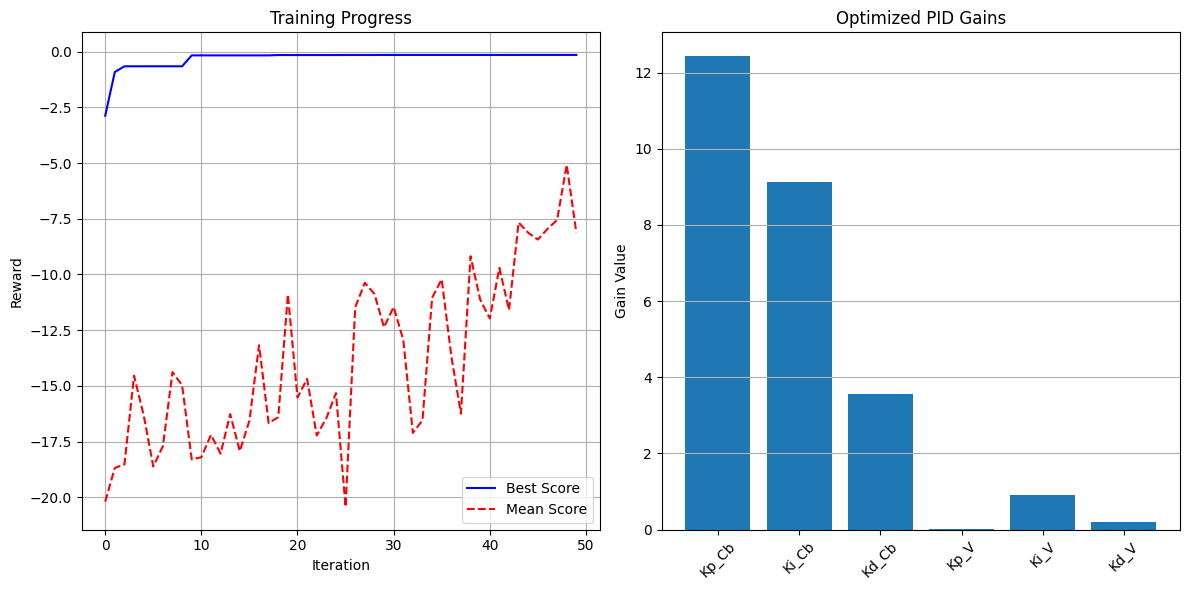

Starting fine-tuning process...
Fine-tuning iteration 1/10: Best Score = -0.1543, Mean Score = -0.2382
Fine-tuning iteration 2/10: Best Score = -0.1543, Mean Score = -0.1735
Fine-tuning iteration 3/10: Best Score = -0.1542, Mean Score = -0.1615
Fine-tuning iteration 4/10: Best Score = -0.1542, Mean Score = -0.1603
Fine-tuning iteration 5/10: Best Score = -0.1542, Mean Score = -0.1565
Fine-tuning iteration 6/10: Best Score = -0.1541, Mean Score = -0.1586
Fine-tuning iteration 7/10: Best Score = -0.1541, Mean Score = -0.1555
Fine-tuning iteration 8/10: Best Score = -0.1541, Mean Score = -0.1545
Fine-tuning iteration 9/10: Best Score = -0.1541, Mean Score = -0.1545
Fine-tuning iteration 10/10: Best Score = -0.1541, Mean Score = -0.1549
Comparing with baseline policy...
Evaluating policy...
Evaluation completed. Total reward: -0.1541
Evaluating policy...
Evaluation completed. Total reward: -31.4662
Comparison results:
  Cb MSE - Best: 0.001712, Baseline: 0.349624, Improvement: 99.51%
   V 

/tmp/ipykernel_3071460/387494661.py:455: RuntimeWarning: invalid value encountered in scalar divide
  v_improvement = ((baseline_mse_v - best_mse_v) / baseline_mse_v) * 100


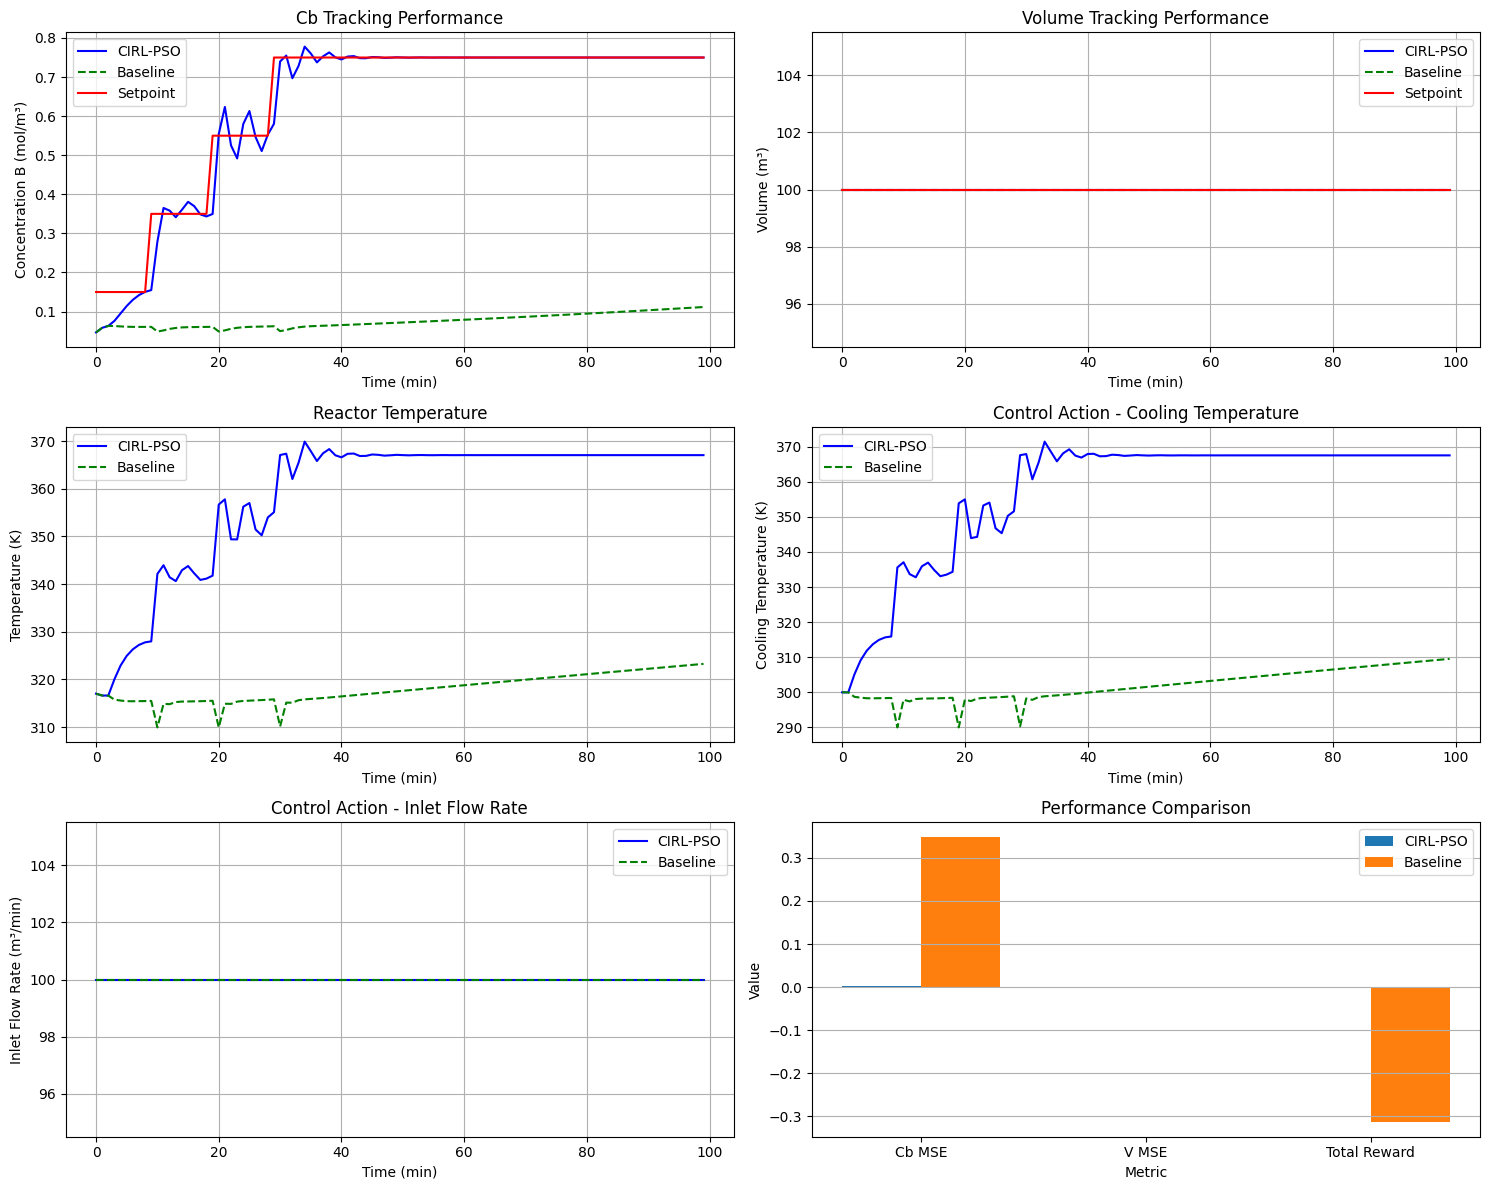

Evaluating policy...


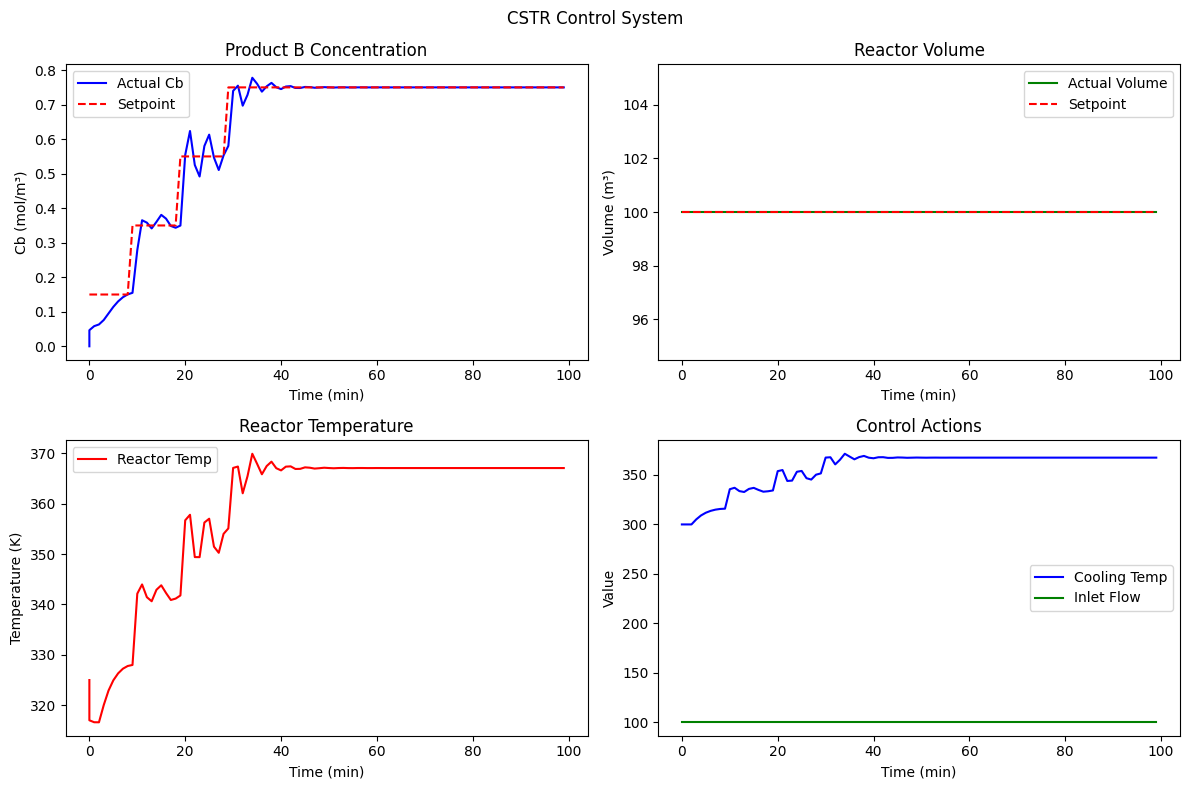

Evaluation completed. Total reward: -0.1541
CIRL-PSO Training and Evaluation Complete!
Best PID Gains: [12.43352103  9.13680211  3.54715152  0.01520976  0.91771147  0.19175819]
Fine-tuned PID Gains: [12.26091494  9.07106646  3.57485859  0.          0.8409687   0.22919732]


In [3]:
def main():
    # Create the CSTR environment
    env = CSTRRLEnv(
        simulation_steps=100,        # Length of each episode
        dt=1.0,                      # Time step (min)
        uncertainty_level=0.0,       # Parameter uncertainty
        noise_level=0.0,             # Measurement noise
        actuator_delay_steps=0,      # Control delay
        transport_delay_steps=0,     # Measurement delay
        enable_disturbances=False    # Enable random disturbances
    )
    
    # Define the setpoint tracking problem for training
    # Training scenario: Step changes in Cb with constant volume
    training_setpoints_Cb = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    training_setpoints_V = [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
    training_setpoint_durations = [10, 10, 10, 10, 10, 10, 10, 10, 10]
    # training_setpoint_durations = [50, 50, 50, 50, 50, 50, 50, 50, 50]
    
    # Initialize the CIRL-PSO trainer
    cirl_trainer = CIRL_PSO(env, num_particles=20, max_iterations=50)
    
    # Optional: Pretrain using historical data if available
    historical_data = {
        'best_pid_gains': np.array([1, -1, -0.62345996, -0.62057259, -0.09185304, -0.98460411]),  # Example values
        'setpoints_Cb': training_setpoints_Cb,
        'setpoints_V': training_setpoints_V,
        'setpoint_durations': training_setpoint_durations
    }
    cirl_trainer.pretrain(historical_data)
    
    # Train the policy
    best_policy, training_history = cirl_trainer.train(
        training_setpoints_Cb, 
        training_setpoints_V, 
        training_setpoint_durations
    )
    
    # Plot training progress
    cirl_trainer.plot_training_progress(training_history)
    
    # Define a new setpoint tracking problem for fine-tuning and evaluation
    # Testing scenario: Different setpoint profile
    testing_setpoints_Cb = [0.15, 0.35, 0.55, 0.75]
    testing_setpoints_V = [100.0, 100.0, 100.0, 100.0]
    testing_setpoint_durations = [10, 10, 10, 10]
    # testing_setpoint_durations = [50, 50, 50, 50]
    # Fine-tune the policy on the new setpoint schedule
    fine_tuned_policy, fine_tuning_history = cirl_trainer.fine_tune(
        best_policy, 
        testing_setpoints_Cb, 
        testing_setpoints_V, 
        testing_setpoint_durations,
        iterations=10
    )
    
    # Define a baseline policy (static PID tuning)
    baseline_policy = np.array([3.09, 0.03, 0.83, 0.84, 1.85, 0.08])  # best static pid
    
    # Compare with baseline
    comparison_data = cirl_trainer.compare_with_baseline(
        fine_tuned_policy, 
        baseline_policy, 
        testing_setpoints_Cb, 
        testing_setpoints_V, 
        testing_setpoint_durations
    )
    
    # Plot comparison results
    cirl_trainer.plot_comparison_results(comparison_data)
    
    # Visualize the final policy in action
    evaluation_data = cirl_trainer.evaluate_policy(
        fine_tuned_policy, 
        testing_setpoints_Cb, 
        testing_setpoints_V, 
        testing_setpoint_durations,
        render=True
    )
    
    # Close the environment
    env.close()
    
    print("CIRL-PSO Training and Evaluation Complete!")
    print(f"Best PID Gains: {best_policy}")
    print(f"Fine-tuned PID Gains: {fine_tuned_policy}")


if __name__ == "__main__":
    main()